In [310]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp as pp
import pandas as pd
decays = pd.read_parquet('decays_ac.parquet')
df_ac = pd.read_excel('acditransitions.xlsx')

In [311]:
aalt

[11594.54, 16944.85]

In [312]:
alpha = 1/137
Rc = ((4/3)*(alpha/219745)**3)*(1/(2.418e-17))
def g(i,j,med,jj):
    '''
    This allows for the cacultation of the decay rate in units of hz

    i(flaot): this is the inintial energy levels ,units are cm^-1
    j(float):this is the level that it decays to in: cm^-2u
    med(float): dipole matrix elemnet in atomic units 
    jj(int): this it the total angular momentum
    '''
    a = ((i-j)**3)*(med)**2/(2*jj + 1)
    return a*Rc

In [313]:
fff = []
aalt = [11594.54, 16944.85, 35850.31] 
M = 0
for i in aalt:
    H = decays[decays['E'] == i]['HF'].tolist()[0]
    for j in H:
        if j == 0:
            fff.append([M,j,0])  
        else:        
            for k in range(-j,j+1):
                 fff.append([M,j,k])
    M = M+1
print(len(fff))

128


In [314]:
df_ac[(df_ac['E1'] == 16944.85) & (df_ac['E2'] == 35850.31)]['Med'].tolist()

[0.77879]

In [315]:
 gr = []
 aalt = [11594.54, 16944.85]
 for i in aalt: 
    c =  df_ac[(df_ac['E1'] == i) & (df_ac['E2'] == 35850.31)]['Med'].tolist()[0]
    jj =    jj = decays[decays['E'] == i]['j'].tolist()[0]
    gr.append(g(35850.31,i,c,jj)) 


In [316]:
det = 1
alpha = 1.0
I = 3/2
gj = 1.3126
gI  =  1.1/3.15245e-14*3/2
AHFS = (0.1712168e4)*10**6

In [317]:
I = 3/2
H_3,m_3 = pp.hamiltonians.hyperfine_coupled(11/2,I,gj,gI,AHFS)
H_2,m_2 = pp.hamiltonians.hyperfine_coupled(9/2,I,gj,gI,(0.1712168e4)*10**5)
H_1,m_1 = pp.hamiltonians.hyperfine_coupled(9/2,I,gj,gI,(0.1712168e4)*10**6)
dq13 = pp.hamiltonians.dqij_two_hyperfine_manifolds(9/2,11/2,I)
dq12 = pp.hamiltonians.dqij_two_hyperfine_manifolds(9/2,11/2,I)

In [318]:
hamiltonians_ac_a = pp.hamiltonian()
hamiltonians_ac_a.add_H_0_block('H_1', H_1)
hamiltonians_ac_a.add_H_0_block('H_2', H_2)
hamiltonians_ac_a.add_H_0_block('H_3', H_3)
hamiltonians_ac_a.add_d_q_block('H_2','H_3',dq12, gamma = gr[1])
hamiltonians_ac_a.add_d_q_block('H_1','H_3',dq13, gamma = gr[0] )
magField = lambda R:np.zeros(R.shape)

In [319]:
decays[decays['E'] == 35850.31]

,E,j,gamma,g,allowed transitions,HF
75,35850.31,5.5,8.492392e+07,1.3126,"[11594.54, 16944.85, 25183.8, 27716.6, 32603.0...","[4, 5, 6, 7]"


In [320]:
e1 = np.unique(np.diagonal(H_1))
e2 = np.unique(np.diagonal(H_2))
e3 = np.unique(np.diagonal(H_3))
e1 = e3[1] - e1[3] 

def laser(delta,delta1,s1,s2,s3):
  laserbeam = {}
  laserbeam['H_1->H_3'] = pp.laserBeams(
        [{'kvec':np.array([1., 0., 0.]), 'pol':np.array([0, 1, 0.]),
          'pol_coord':'cartesian', 'delta':delta, 's':s1}],
        beam_type= pp.infinitePlaneWaveBeam)
  laserbeam['H_2->H_3'] = pp.laserBeams([{'kvec':np.array([0, 0, 1]), 'pol':np.array([0,0,1]),
       'pol_coord':'spherical', 'delta':delta1, 's':s3}],beam_type =  pp.infinitePlaneWaveBeam)
  #laserbeam['H_17->H_34'] = pp.laserBeams([{'kvec':np.array([0, 0, 1]), 'pol':np.array([0,0,1]),
       #'pol_coord':'spherical', 'delta':delta1, 's':s3}],beam_type =  pp.infinitePlaneWaveBeam)#s3 adds a re
  return laserbeam

In [321]:
t_0

0.001

In [322]:
decays[decays['E'] == 35850.31]


,E,j,gamma,g,allowed transitions,HF
75,35850.31,5.5,8.492392e+07,1.3126,"[11594.54, 16944.85, 25183.8, 27716.6, 32603.0...","[4, 5, 6, 7]"


In [323]:
laserbeam  = laser(e1,e1,0,0,0)
rateeq = pp.rateeq(laserbeam,magField,hamiltonians_ac_a)

In [324]:
t_0 = 1e-3
N0  = np.zeros((rateeq.hamiltonian.n,))
N0[127] = 1
rateeq.set_initial_pop(N0)
rateeq.evolve_populations([0,0.0000005/t_0],max_step=1)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.003e-11 ...  5.000e-04  5.000e-04]
        y: [[ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            ...
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            [ 1.000e+00  9.990e-01 ...  5.188e-06  1.091e-06]]
      sol: None
 t_events: None
 y_events: None
     nfev: 101780
     njev: 0
      nlu: 0

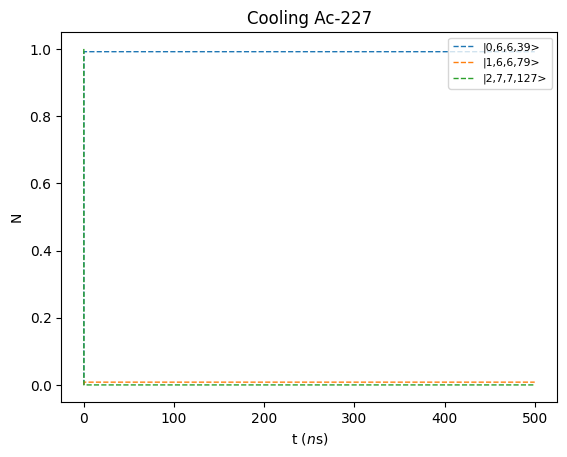

In [327]:
# this plots the rate eqautions to visualize population evolution this will be filterd based on levels that don't get more thana certain population  
import matplotlib.colors as mcolors

used_colors = set()

def get_distinct_color():
    base_colors = list(mcolors.TABLEAU_COLORS.values())  # You can use other color palettes as well
    available_colors = [color for color in base_colors if color not in used_colors]

    if not available_colors:
        # Reset used_colors if all colors have been used
        used_colors.clear()
        available_colors = base_colors

    color = available_colors[0]
    used_colors.add(color)
    return color
 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

i = 0
ee = 1
R = []
spec = [159, 383, 927]
for bob in range(len(rateeq.sol.y)):
    ee = fff[bob][0]
    ff = fff[bob][1]
    m = fff[bob][2]
    k = rateeq.sol.y[bob][100]
    ll = rateeq.sol.y[bob][0]

    # Get a distinct color


    # Plot only if k > 0.01
    if  ll == 1 or k > 0.001:
        color = get_distinct_color()
        ax.plot(1e9*t_0*rateeq.sol.t[:], rateeq.sol.y[bob,],'--',color = color, linewidth=1.0,
                label='|' + ','.join([str(ee), str(ff), str(m), str(bob)]) + '>')
        i += 3

plt.legend(fontsize='7.8', loc='upper right')
plt.title('Cooling Ac-227')
plt.xlabel('t ($n$s)')
plt.ylabel('N')
plt.show()
